# PSF Photometry in Crowded Fields with Photutils

This notebook exemplifies the use of photutils.psf to perform point spread function (PSF) photometry in crowded fields simulated assuming that the PSF of the stars has a Gaussian shape

## Create an artificial image

Let's create an artificial image using the  functionality in `photutils.datasets`.  Of course you'd use an image from a telescope if you're working with real data, but here we want to know the "right answer" so we create artificial stars.

In [1]:
from collections import OrderedDict

from photutils.datasets import make_random_gaussians_table
from photutils.datasets import make_noise_image
from photutils.datasets import make_gaussian_sources_image

num_sources = 150
min_flux = 500
max_flux = 5000
min_xmean = 16
max_xmean = 240
sigma_psf = 2.0

param_ranges = [('flux', [min_flux, max_flux]),
                ('x_mean', [min_xmean, max_xmean]),
                ('y_mean', [min_xmean, max_xmean]),
                ('x_stddev', [sigma_psf, sigma_psf]),
                ('y_stddev', [sigma_psf, sigma_psf]),
                ('theta', [0, 0])]
param_ranges = OrderedDict(param_ranges)

starlist = make_random_gaussians_table(num_sources, param_ranges, random_state=123)
shape = (256, 256)
image = (make_gaussian_sources_image(shape, starlist) +
         make_noise_image(shape, distribution='poisson', mean=6., random_state=123) + 
         make_noise_image(shape, distribution='gaussian', mean=0., stddev=2., random_state=123))
starlist

flux,x_mean,y_mean,x_stddev,y_stddev,theta,amplitude
float64,float64,float64,float64,float64,float64,float64
3634.1113351903773,53.17008606235767,19.671915716208627,2.0,2.0,0.0,144.59669568545908
1787.6270072767077,190.94353811199045,177.54529799533591,2.0,2.0,0.0,71.1274186531649
1520.831541038914,80.18420214731883,17.733203164202486,2.0,2.0,0.0,60.51196434160197
2980.9164608730107,84.64922474582083,35.00019014773233,2.0,2.0,0.0,118.60689742298452
3737.610364035034,165.01856823832898,66.51164394080529,2.0,2.0,0.0,148.7147911969185
2403.9790705600744,40.95184644012833,212.02789558760233,2.0,2.0,0.0,95.65128804227403
4913.43889273077,164.93142853193794,97.4410952292254,2.0,2.0,0.0,195.49952183951774
3581.7338236318847,214.87992155947387,136.9510254876131,2.0,2.0,0.0,142.51266071761233
2664.193556679624,171.97372408473103,143.25511989545117,2.0,2.0,0.0,106.00489347478496


## Initialize instances for the IterativelySubtractedPSFPhotometry object

In order to initiliaze an `IterativelySubtractedPSFPhotometry` object, we have to load some other objects which will be used to perform PSF photometry. More precisely, the required parts are:  a fitter (e.g., from `astropy.fitting`), a source detection (e.g., `DAOStarFinder` or `IRAFStarFinder`, from `photutils.detection`), a grouping functionality (e.g., `DBSCANGroup` from `photutils.psf`), a background estimator (e.g. `MedianBackground` or `MMMBackground`, from `photutils.background`), and a PSF model (e.g., `IntegratedGaussianPRF` from `photutils.psf`).

In [2]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DBSCANGroup
from photutils.psf import IntegratedGaussianPRF
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

bkgrms = MADStdBackgroundRMS()

std = bkgrms(image)

iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)

grouper = DBSCANGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)

mmm_bkg = MMMBackground()

psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

fitter = LevMarLSQFitter()

It's worth noting that the values of the `IRAFStarFinder` parameters were chosen purely empirically and optimum values may vary according to the data.

## Perform photometry

To perform PSF photometry, we need first to initialize a `DAOPhotPSFPhotometry` object by passing along the objects loaded in the previous cell. Similarly to `DBSCANGroup` and `DAOStarFinder`, the `DAOPhotPSFPhotometry` class was designed such that its objects are "callable", meaning that one can call them in the same fashion as calling a regular function. This, in fact, will call the `do_photometry` method to actually perform photometry. 

In [3]:
from photutils.psf import IterativelySubtractedPSFPhotometry

photometry = IterativelySubtractedPSFPhotometry(finder=iraffind, group_maker=grouper,
                                                bkg_estimator=mmm_bkg, psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11))
result_tab = photometry(image)
residual_image = photometry.get_residual_image()

The warning here, raised by LevMarLSQFitter, lets us know that some sources (or groups of sources) may not have been fit successfully. Let's check the residuals to see which sources were not fitted correctly.

## Plot original and residual images

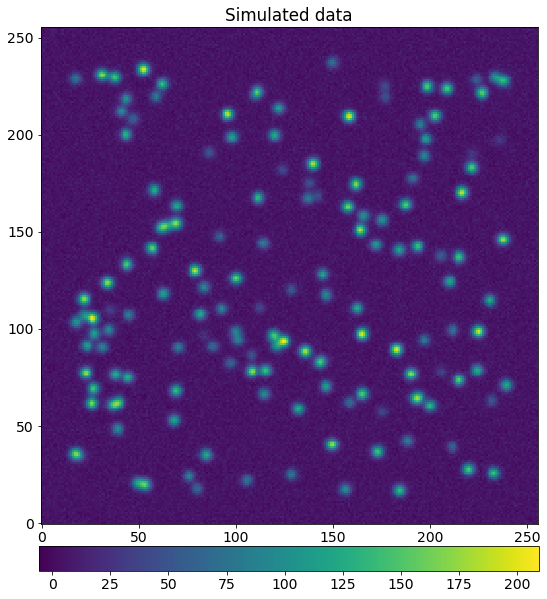

In [4]:
import numpy as np
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (20,10)
rcParams['image.interpolation'] = 'nearest'
rcParams['image.origin'] = 'lower'
rcParams['font.size'] = 14

plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

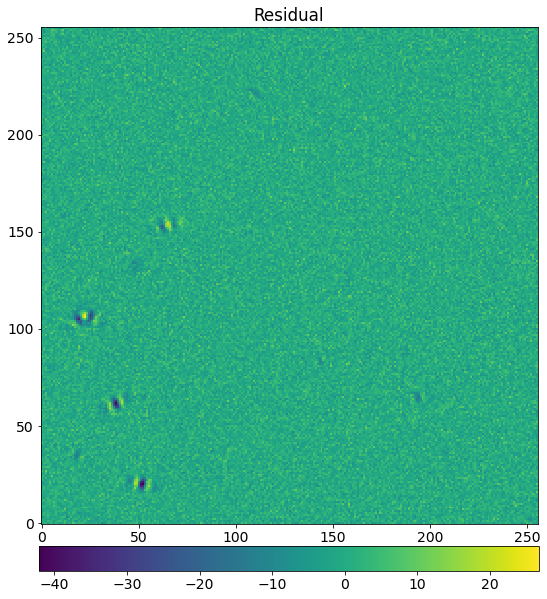

In [5]:
plt.imshow(residual_image)
plt.title('Residual')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

In [6]:
result_tab.sort('id')
result_tab

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64
156.2106801438022,156.26080411849117,17.292030076120508,17.38455161919878,2152.0167290793606,2331.2646860940586,1,1,21.328820860629406,0.026170980588116864,0.026175562410964612,1
55.346234463152314,55.8804786421865,19.595940045344264,18.993959538495982,327.2999971052257,644.0135867376406,1,1,69.88275227315238,0.31222406450427637,0.3112224573320914,2
47.93298786583789,47.553211746295055,20.937581774614685,20.976545838621135,771.1735558228356,1136.827389685389,2,1,69.85084250011151,0.17646021298975975,0.17566615342598454,2
184.28123541356186,184.36815893013753,16.81980564275223,16.800043326795034,3173.863151369522,3428.4195365948967,2,2,22.02598830022159,0.018380778952040586,0.01837572390785254,1
80.0772903581649,80.16130214541504,17.862018658791893,17.741212224101336,1572.353121365605,1583.6671622911742,3,3,23.89472483190535,0.04325676632233426,0.04349878041552272,1
21.27782007972703,21.948698330355686,33.794121586702275,33.61163184908735,182.21410390288108,297.0526207362935,3,2,28.84820195728827,0.27962462767448304,0.2778502452943044,2
52.52105849134431,51.91999850273165,19.902682302714652,20.015853835760254,5091.907598820761,4947.943095145097,4,4,136.44663966572702,0.07916639105348049,0.0788687310708678,1
79.21298871823937,79.07587845178278,34.40552438706051,35.1943431888373,30.61771897444355,75.00910526894168,4,3,22.62160060521437,0.8626545423202909,0.8669589986314976,2
14.873111155548647,14.064953216163678,36.82330637769749,36.67807775141644,66.9846378733909,152.59385539173428,5,2,28.84737626640459,0.544261044115547,0.5407488368512179,2


## Photometry with fixed positions

Now, let's perform photometry for the case that star positions are held fixed and one is interested only in fitting the flux. This is useful  when all stellar positions are known a priori with a very high accuracy. In this case, the parameter space is reduced to the 1D real space, making the optimizer much more likely to find the global optimum. 

In [7]:
from photutils.psf import BasicPSFPhotometry

In [8]:
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True

In [9]:
positions = starlist['x_mean', 'y_mean']
positions['x_mean'].name = 'x_0'
positions['y_mean'].name = 'y_0'

In [10]:
photometry = BasicPSFPhotometry(group_maker=grouper, bkg_estimator=mmm_bkg,
                                psf_model=psf_model, fitter=LevMarLSQFitter(),
                                fitshape=(11,11))
result_tab = photometry(image=image, init_guesses=positions)
residual_image = photometry.get_residual_image()

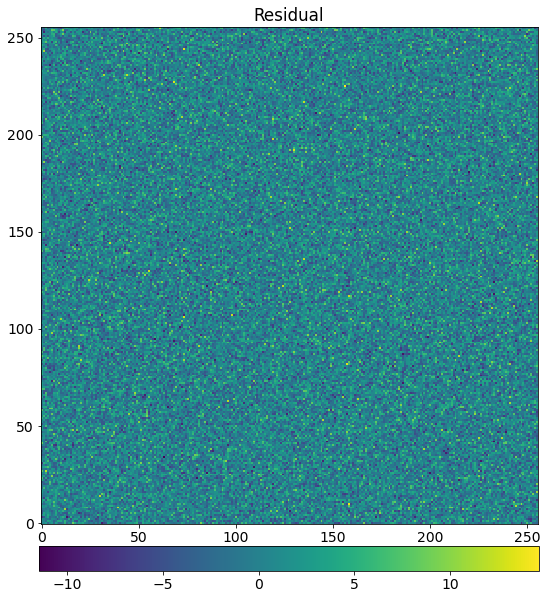

In [11]:
plt.imshow(residual_image)
plt.title('Residual')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

In [12]:
result_tab.sort('id')
result_tab

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc
float64,float64,float64,int64,int64,float64,float64,float64,float64
53.17008606235767,19.671915716208627,4830.359186491502,1,1,53.17008606235767,19.671915716208627,3649.9696100814335,21.683250290351804
190.94353811199045,177.54529799533591,1673.294297947797,2,2,190.94353811199045,177.54529799533591,1789.4353475749997,22.40833480420331
80.18420214731883,17.733203164202486,1555.1718213144234,3,3,80.18420214731883,17.733203164202486,1583.0293188569508,23.633023478549482
84.64922474582083,35.00019014773233,2795.502587678995,4,4,84.64922474582083,35.00019014773233,3004.679933123116,24.243044528536064
165.01856823832898,66.51164394080529,3615.4761786102526,5,5,165.01856823832898,66.51164394080529,3818.093959698896,23.868183352761204
40.95184644012833,212.02789558760233,2593.917516024712,6,6,40.95184644012833,212.02789558760233,2425.2070729121087,22.571579084456175
164.93142853193794,97.4410952292254,4641.795812866067,7,7,164.93142853193794,97.4410952292254,5005.430812940194,23.060973594863643
214.87992155947387,136.9510254876131,3381.66445738088,8,8,214.87992155947387,136.9510254876131,3644.390128336999,21.19608945395806
171.97372408473103,143.25511989545117,2471.0523083654093,9,9,171.97372408473103,143.25511989545117,2669.447258516995,30.371857261333634


Now, let's create a scatter plot to compare the estimated and the ground truth fluxes 

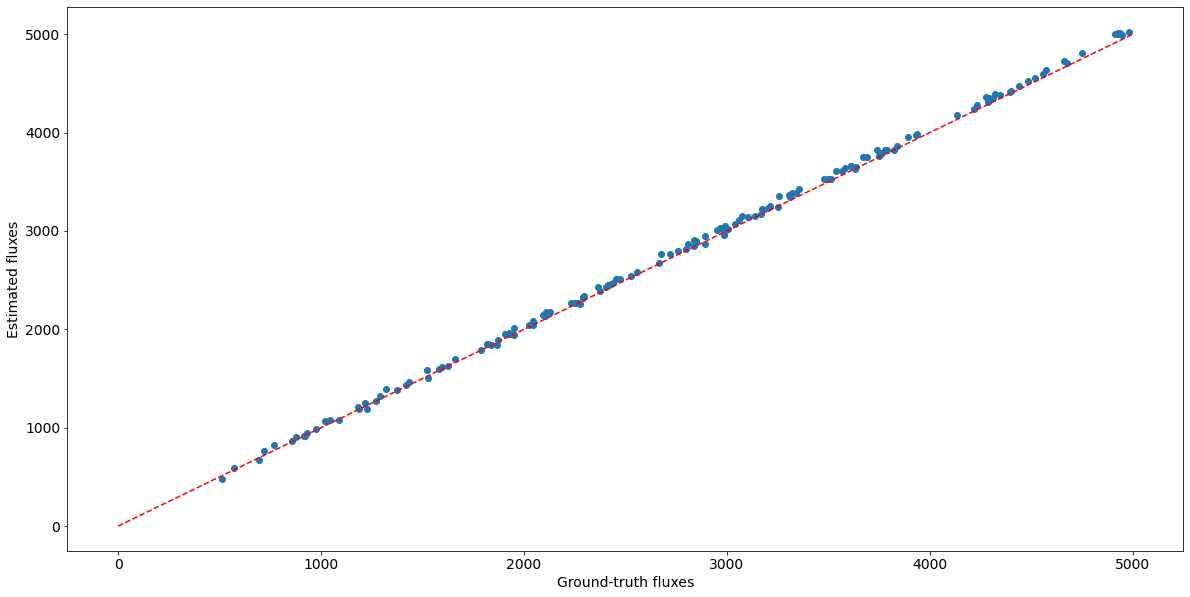

In [13]:
plt.scatter(starlist['flux'], result_tab['flux_fit'])
plt.xlabel('Ground-truth fluxes')
plt.ylabel('Estimated fluxes')
xr = np.arange(5000)
plt.plot(xr, xr, linestyle='dashed', color='red')

We'll also print the linear correlation coefficient and the root mean squared error (rmse) which are often used to check the correlation and the bias between two data sets.

In [14]:
print(np.corrcoef(starlist['flux'], result_tab['flux_fit'])[0][1])
print(np.sqrt(np.mean((starlist['flux'] - result_tab['flux_fit'])**2)))

0.9997843501399931
43.41098049572659


A correlation coefficient of .99978 means that the fitting process is very consistent, i.e., the fitter was able to correctly estimate most of the star fluxes. An RMSE of approximately 43 means that the fluxes estimates are biased, on average, by 43.

Now let's check how the relative error looks like as a function of the simulated ("true") flux

Text(0, 0.5, 'Estimate Relative Error')

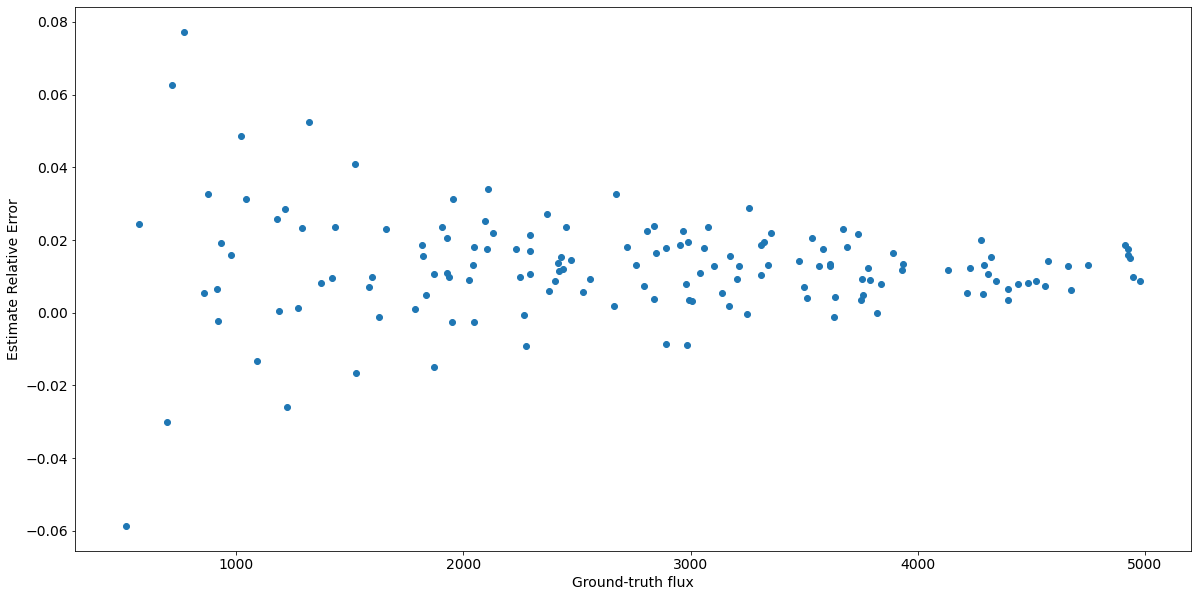

In [15]:
plt.scatter(starlist['flux'], (result_tab['flux_fit'] - starlist['flux'])/starlist['flux'])
plt.xlabel('Ground-truth flux')
plt.ylabel('Estimate Relative Error')

As expected, the relative error decreases as the flux increases. 